In [3]:
# Import libraries
import pandas as pd
import numpy as np
import re
import unicodedata
import joblib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sentence_transformers import SentenceTransformer
import shap

# Step 1: Data Preprocessing & Cleaning
def clean_text(text):
    """Clean the text by normalizing, removing special characters, and converting to lowercase."""
    text = unicodedata.normalize("NFKD", text)  # Fix encoding issues
    text = re.sub(r'[^a-zA-Z0-9., ]', '', text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase
    return text

# Load dataset
resume_df = pd.read_csv("UpdatedResumeDataSet.csv")  # Replace with your file path
job_df = pd.read_csv("job_descriptions.csv")  # Replace with your file path

# Combine relevant text fields
resume_df['Combined_Text'] = resume_df['Category'] + " " + resume_df['Resume']
job_df['Combined_Text'] = job_df['Job Title'] + " " + job_df['Job Description'] + " " + job_df['skills']

# Clean text fields
resume_df['Combined_Text'] = resume_df['Combined_Text'].apply(clean_text)
job_df['Combined_Text'] = job_df['Combined_Text'].apply(clean_text)

KeyboardInterrupt: 

Data Preprocessing & Cleaning

In [4]:
import pandas as pd
import re
import unicodedata

# Load dataset (replace with actual path)
df = pd.read_csv("unified_dataset.csv")

# Drop missing values
df.dropna(inplace=True)

# Function to clean text
def clean_text(text):
    text = unicodedata.normalize("NFKD", text)  # Fix encoding issues
    text = re.sub(r'[^a-zA-Z0-9., ]', '', text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase
    return text

# Apply text cleaning
df['Resume_Text'] = df['Resume_Text'].apply(clean_text)
df['Matched_Job_Description'] = df['Matched_Job_Description'].apply(clean_text)
df['Matched_Job_Skills'] = df['Matched_Job_Skills'].apply(clean_text)

df.head()  # Display cleaned data


,Resume_Category,Resume_Text,Matched_Job_Title,Matched_Job_Description,Matched_Job_Skills
0,Data Science,"skills programming languages python pandas, n...",Data Analyst,data scientists use their expertise in data an...,machine learning algorithms and libraries e.g....
1,Data Science,education details may 2013 to may 2017 b.e u...,Data Scientist,machine learning engineers develop machine lea...,machine learning algorithms python programming...
2,Data Science,"areas of interest deep learning, control syste...",Electrical Designer,electrical engineers design and develop electr...,electrical engineering circuit design electron...
3,Data Science,skills a r a python a sap hana a tableau a sap...,Marketing Analyst,"analyze data sets, generate insights, and prov...","data analysis tools e.g., sql, python data vis..."
4,Data Science,"education details mca ymcaust, faridabad, ...",Data Analyst,"data quality analysts ensure the accuracy, com...",data quality assessment and improvement data p...


TF-IDF Vectorization

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the unified dataset
df = pd.read_csv("unified_dataset.csv")  # Update with actual path

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Apply TF-IDF transformation
df_tfidf = tfidf.fit_transform(df["Resume_Text"] + " " + df["Matched_Job_Description"] + " " + df["Matched_Job_Skills"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(df_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Concatenate with original dataset
df_final = pd.concat([df, tfidf_df], axis=1)

# Save the processed dataset
df_final.to_csv("processed_dataset.csv", index=False)


Dimensionality Reduction

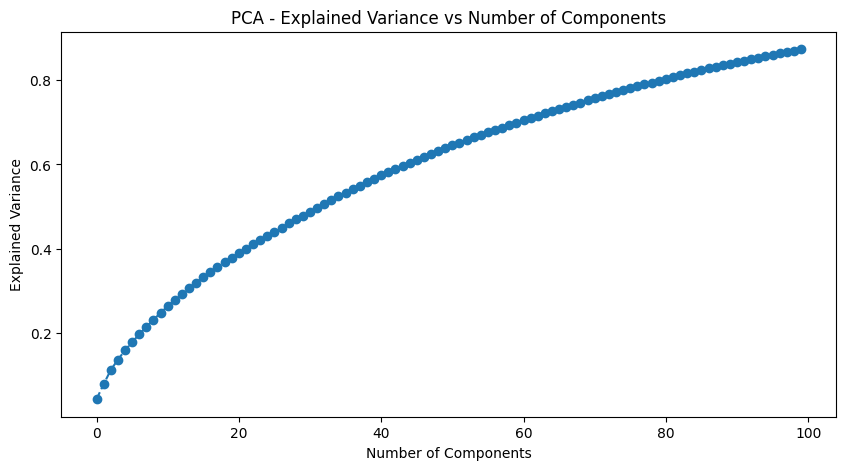

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Standardize TF-IDF features
scaler = StandardScaler()
tfidf_scaled = scaler.fit_transform(tfidf_df)

# Apply PCA (keeping 100 components)
pca = PCA(n_components=100)
tfidf_pca = pca.fit_transform(tfidf_scaled)

# Plot explained variance to decide optimal components
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.title("PCA - Explained Variance vs Number of Components")
plt.show()

# Convert PCA results to DataFrame
pca_df = pd.DataFrame(tfidf_pca, columns=[f"PC{i+1}" for i in range(100)])

# Concatenate with original dataset (keeping Resume_Category for modeling)
df_pca = pd.concat([df[["Resume_Category"]], pca_df], axis=1)

# Save the reduced dataset
df_pca.to_csv("reduced_dataset.csv", index=False)


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Prepare data for model training
X = df_final.drop(columns=["Resume_Category", "Resume_Text", "Matched_Job_Title", "Matched_Job_Description", "Matched_Job_Skills"])  # Use the TF-IDF features
y = df_final["Resume_Category"]  # Target variable

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
accuracy = rf_model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 99.48%


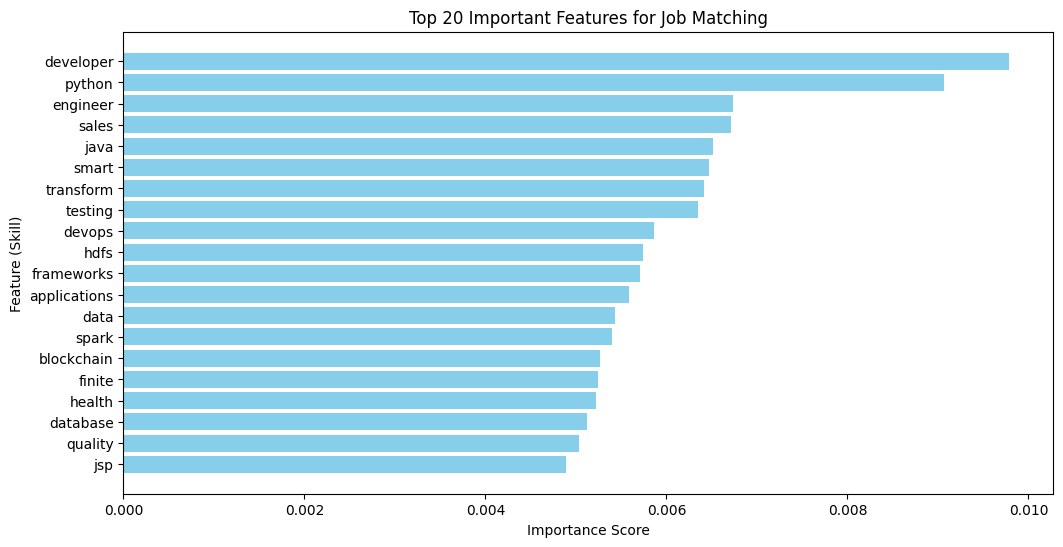

In [8]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to sort them
feat_importance_df = pd.DataFrame({"Feature": tfidf.get_feature_names_out(), "Importance": feature_importances})
feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 6))
plt.barh(feat_importance_df["Feature"][:20], feat_importance_df["Importance"][:20], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.ylabel("Feature (Skill)")
plt.title("Top 20 Important Features for Job Matching")
plt.show()


                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         3
                     Arts       1.00      1.00      1.00         6
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         7
         Business Analyst       1.00      1.00      1.00         4
           Civil Engineer       1.00      1.00      1.00         9
             Data Science       1.00      1.00      1.00         5
                 Database       1.00      1.00      1.00         8
          DevOps Engineer       1.00      0.93      0.96        14
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         7
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1.00      1.00        12
                   Hadoop       1.00      1.00      1.00     

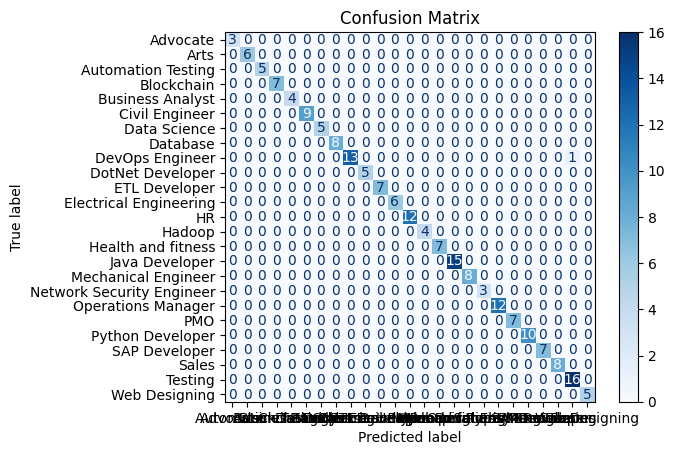

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predictions
y_pred = rf_model.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [10]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for tuning
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearch
print("Best parameters found: ", grid_search.best_params_)

# Use the best model from grid search
best_rf_model = grid_search.best_estimator_

# Evaluate with the best model
y_pred_best = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_best))


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         3
                     Arts       1.00      1.00      1.00         6
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         7
         Business Analyst       1.00      1.00      1.00         4
           Civil Engineer       1.00      1.00      1.00         9
             Data Science       1.00      1.00      1.00         5
                 Database       1.00      1.00      1.00         8
          DevOps Engineer       1.00      0.93      0.96        14
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         7
   Electrical Enginee

<Figure size 640x480 with 0 Axes>

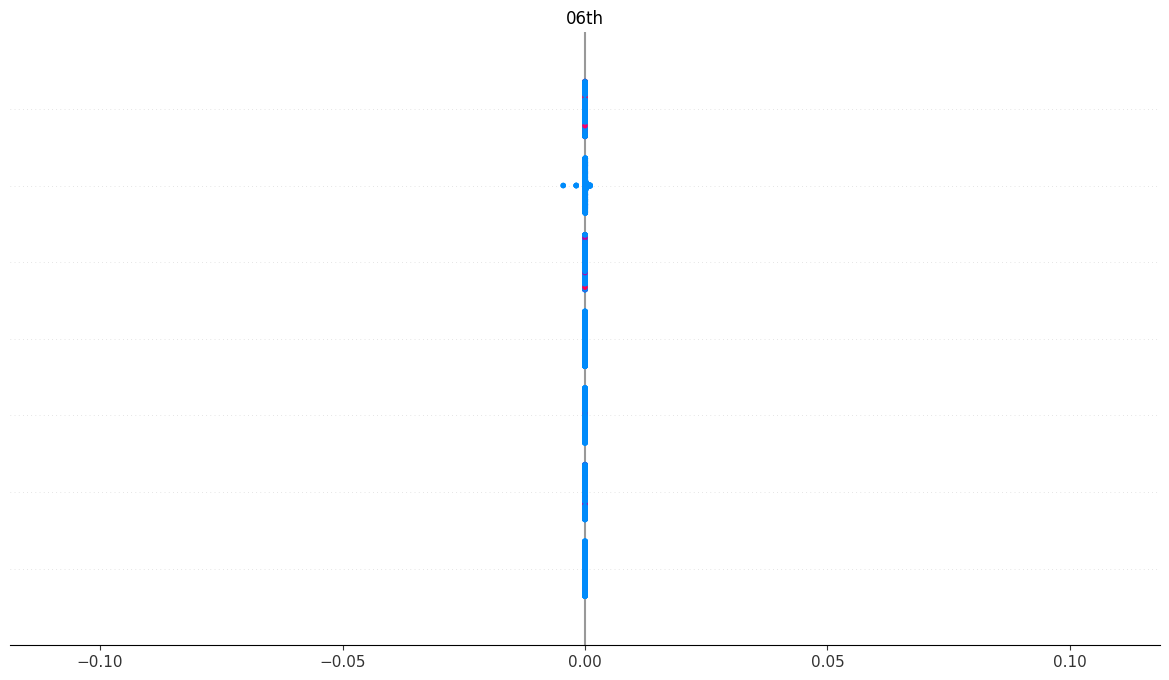

In [11]:
# Step 8: Model Interpretation with SHAP
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train)


In [12]:
# Step 9: Save the Model and Vectorizer
joblib.dump(best_rf_model, "best_rf_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

# Optional: Save the PCA and scaler if needed for future use
joblib.dump(pca, "pca_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import joblib

# Load datasets
resume_df = pd.read_csv("UpdatedResumeDataSet.csv")  # Ensure it has 'Resume'
job_df = pd.read_csv("job_descriptions.csv")  # Ensure it has 'Job Description' and 'skills'

# Combine text fields for comparison
resume_df['Combined_Text'] = resume_df['Resume']
job_df['Combined_Text'] = job_df['Job Description'] + " " + job_df['skills']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
resume_tfidf = vectorizer.fit_transform(resume_df['Combined_Text'])
job_tfidf = vectorizer.transform(job_df['Combined_Text'])

# Compute similarity scores
similarity_matrix = cosine_similarity(resume_tfidf, job_tfidf)

# Get best matching job for each resume
best_match_indices = similarity_matrix.argmax(axis=1)
resume_df['Best_Match_Job'] = best_match_indices
resume_df['Similarity_Score'] = similarity_matrix.max(axis=1) * 100  # Convert to percentage

# Identify missing keywords
feature_names = vectorizer.get_feature_names_out()
resume_features = resume_tfidf.toarray()
job_features = job_tfidf.toarray()

suggestions = []
for i, job_idx in enumerate(best_match_indices):
    resume_keywords = set([feature_names[j] for j in resume_features[i].nonzero()[0]])
    job_keywords = set([feature_names[j] for j in job_features[job_idx].nonzero()[0]])
    missing_keywords = list(job_keywords - resume_keywords)
    suggestions.append(", ".join(missing_keywords[:10]))  # Limit to top 10 missing keywords

resume_df['Suggestions'] = suggestions

# Save the updated dataset
resume_df.to_csv("resume_suggestions.csv", index=False)

print("Suggestions generated successfully!")

MemoryError: Unable to allocate 88.9 GiB for an array with shape (1615940, 7384) and data type float64

In [1]:
import joblib

# Save the model
joblib.dump(best_rf_model, "best_rf_model.pkl")

# Save the vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

# Optional: Save the PCA and scaler if needed for future use
joblib.dump(pca, "pca_model.pkl")
joblib.dump(scaler, "scaler.pkl")

NameError: name 'best_rf_model' is not defined